# CLIP Interactive Test
Load the best checkpoint and test with any image + text descriptions.

In [1]:

import torch
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
import requests
from io import BytesIO

from clip_from_the_scratch.clip_model import clip_vit_b32, clip_small
from clip_from_the_scratch.train import SimpleTokenizer, get_image_transform, find_best_checkpoint

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


## 1. Load Best Checkpoint

In [2]:
CHECKPOINT_DIR = "./checkpoints"

# Auto-find best checkpoint
best_path, best_loss = find_best_checkpoint(CHECKPOINT_DIR)
print(f"Best checkpoint: {best_path} (loss: {best_loss:.4f})")

# Load checkpoint and figure out model type from saved args
checkpoint = torch.load(best_path, map_location=device, weights_only=True)
saved_args = checkpoint.get("args", {})
model_type = saved_args.get("model", "vit-b/32")
print(f"Model type: {model_type}, trained for {checkpoint['epoch']} epochs")

# Create model
if model_type == "small":
    model = clip_small()
else:
    model = clip_vit_b32()

# Strip "_orig_mod." prefix from torch.compile() saved checkpoints
state_dict = checkpoint["model_state_dict"]
state_dict = {k.removeprefix("_orig_mod."): v for k, v in state_dict.items()}

model.load_state_dict(state_dict)
model = model.to(device)
model.eval()

# Tokenizer and image transform
tokenizer = SimpleTokenizer(context_length=model.context_length)
transform = get_image_transform(image_size=224, is_train=False)

print("Model loaded!")

Best checkpoint: ./checkpoints/clip_ep05_3.3415.pt (loss: 3.3415)
Model type: vit-b/32, trained for 5 epochs
Model loaded!


## 2. Helper Functions

In [3]:
def load_image(source):
    """Load image from URL or local path."""
    if source.startswith(("http://", "https://")):
        response = requests.get(source, timeout=10)
        img = Image.open(BytesIO(response.content)).convert("RGB")
    else:
        img = Image.open(source).convert("RGB")
    return img


@torch.no_grad()
def predict(image_source, text_labels):
    """
    Given an image and a list of text descriptions,
    compute similarity scores and rank them.
    
    Args:
        image_source: URL string or local file path
        text_labels: list of text descriptions
    
    Returns:
        List of (label, probability) sorted by probability descending
    """
    # Load and preprocess image
    img = load_image(image_source)
    img_tensor = transform(img).unsqueeze(0).to(device)  # (1, 3, 224, 224)
    
    # Tokenize texts
    text_tokens = tokenizer(text_labels).to(device)  # (N, 77)
    
    # Encode
    image_features = model.encode_image(img_tensor)   # (1, embed_dim)
    text_features = model.encode_text(text_tokens)    # (N, embed_dim)
    
    # Cosine similarity -> softmax probabilities
    logit_scale = model.logit_scale.exp().clamp(max=100.0)
    similarity = (logit_scale * image_features @ text_features.t()).squeeze(0)  # (N,)
    probs = F.softmax(similarity, dim=0)
    
    # Sort by probability
    sorted_indices = probs.argsort(descending=True)
    results = [(text_labels[i], probs[i].item()) for i in sorted_indices]
    return img, results


def show_prediction(image_source, text_labels):
    """Predict and visualize results."""
    img, results = predict(image_source, text_labels)
    
    fig, (ax_img, ax_bar) = plt.subplots(1, 2, figsize=(14, 5),
                                          gridspec_kw={"width_ratios": [1, 1.2]})
    
    # Show image
    ax_img.imshow(img)
    ax_img.axis("off")
    ax_img.set_title("Input Image")
    
    # Show probabilities as horizontal bar chart
    labels = [r[0] for r in results]
    probs = [r[1] for r in results]
    colors = ["#2ecc71" if i == 0 else "#3498db" for i in range(len(results))]
    
    y_pos = range(len(labels))
    ax_bar.barh(y_pos, probs, color=colors)
    ax_bar.set_yticks(y_pos)
    ax_bar.set_yticklabels(labels)
    ax_bar.invert_yaxis()
    ax_bar.set_xlabel("Probability")
    ax_bar.set_title("CLIP Prediction")
    
    for i, (label, prob) in enumerate(results):
        ax_bar.text(prob + 0.01, i, f"{prob:.1%}", va="center")
    
    plt.tight_layout()
    plt.show()
    
    return results

## 3. Test with Examples
Change the image URL and text labels to whatever you want to test.

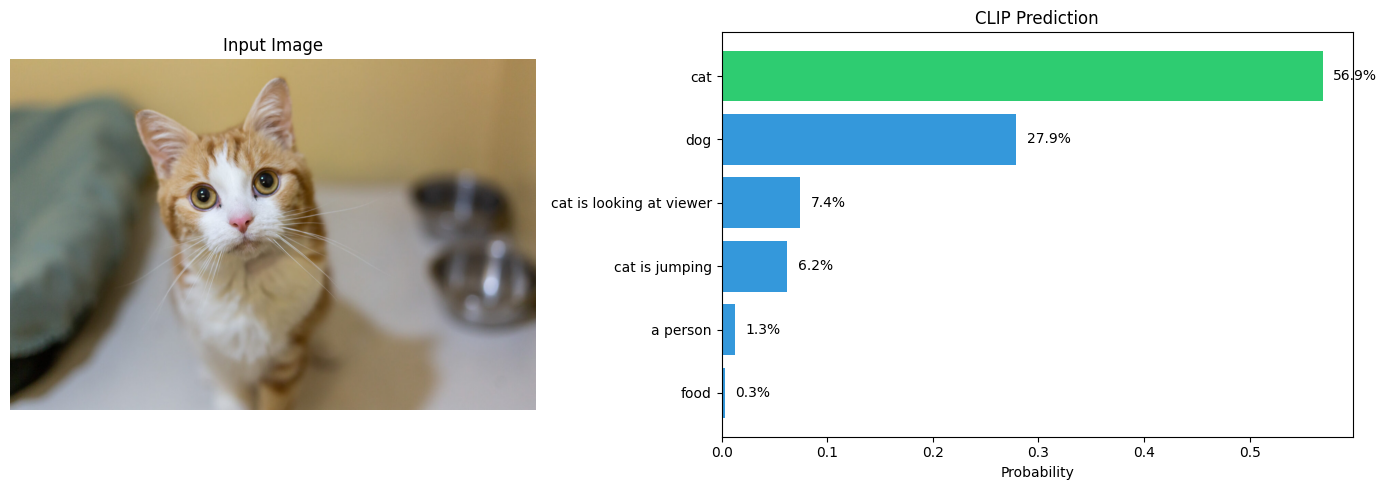

In [21]:
# Example: test with a sample image
# Replace with any image URL (Coupang, Amazon, etc.) or local file path

image_url = "https://www.scottishspca.org/wp-content/uploads/2024/09/CATS-INVERNESS-JUNE-24-13-1536x1024.jpg"

text_labels = [
    "cat",
    "cat is looking at viewer",
    "cat is jumping",
    "a person",
    "food",
    "dog"
]

results = show_prediction(image_url, text_labels)

## 4. Test with Product Images
Paste a product image URL from Coupang/Amazon and describe candidate categories.

In [ ]:
# Example: product image classification
# Paste your product image URL here:

product_url = "YOUR_IMAGE_URL_HERE"  # <-- replace this

product_labels = [
    "a photo of a laptop",
    "a photo of headphones",
    "a photo of a phone case",
    "a photo of a keyboard",
    "a photo of shoes",
    "a photo of a backpack",
]

# results = show_prediction(product_url, product_labels)

## 5. Compare Multiple Images
Given one text query, rank multiple images by similarity.

In [ ]:
@torch.no_grad()
def rank_images(image_sources, text_query):
    """
    Given multiple images and one text query,
    rank images by how well they match the text.
    """
    images = []
    img_tensors = []
    for src in image_sources:
        img = load_image(src)
        images.append(img)
        img_tensors.append(transform(img))
    
    img_batch = torch.stack(img_tensors).to(device)  # (N, 3, 224, 224)
    text_tokens = tokenizer([text_query]).to(device)  # (1, 77)
    
    image_features = model.encode_image(img_batch)  # (N, embed_dim)
    text_features = model.encode_text(text_tokens)  # (1, embed_dim)
    
    logit_scale = model.logit_scale.exp().clamp(max=100.0)
    similarity = (logit_scale * image_features @ text_features.t()).squeeze(1)  # (N,)
    probs = F.softmax(similarity, dim=0)
    
    sorted_indices = probs.argsort(descending=True)
    
    fig, axes = plt.subplots(1, len(images), figsize=(5 * len(images), 5))
    if len(images) == 1:
        axes = [axes]
    
    for rank, idx in enumerate(sorted_indices):
        axes[rank].imshow(images[idx])
        axes[rank].set_title(f"#{rank+1}: {probs[idx]:.1%}", fontsize=14)
        axes[rank].axis("off")
    
    fig.suptitle(f'Query: "{text_query}"', fontsize=16)
    plt.tight_layout()
    plt.show()


# Example usage:
# rank_images(
#     ["url1.jpg", "url2.jpg", "url3.jpg"],
#     "a red sports car"
# )

## 6. Raw Similarity Scores
For debugging — see raw cosine similarity without softmax.

In [ ]:
@torch.no_grad()
def raw_similarity(image_source, text_labels):
    """Show raw cosine similarities (before temperature scaling)."""
    img = load_image(image_source)
    img_tensor = transform(img).unsqueeze(0).to(device)
    text_tokens = tokenizer(text_labels).to(device)
    
    image_features = model.encode_image(img_tensor)
    text_features = model.encode_text(text_tokens)
    
    # Raw cosine similarity (no temperature)
    cos_sim = (image_features @ text_features.t()).squeeze(0)
    
    print(f"Logit scale (temperature): {model.logit_scale.exp().item():.2f}")
    print(f"\n{'Text':50s} {'Cosine Sim':>10s}")
    print("-" * 62)
    for label, sim in sorted(zip(text_labels, cos_sim.tolist()), key=lambda x: -x[1]):
        print(f"{label:50s} {sim:10.4f}")


# Example:
# raw_similarity("your_image.jpg", ["text1", "text2", "text3"])